<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/main/DL_recommender_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [232]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras import backend

In [4]:
#path ='/content/drive/MyDrive/DTU/ABA'
path = '..'
df = pd.read_csv(path + '/recommender.csv')

In [5]:
len(df)

16849468

In [6]:
len(df.drop_duplicates())

11840834

In [8]:
df.to_csv('../recommender.csv', index=False)

In [10]:
df.head()

,review_score,price,customer_state,order_status,seller_state,order_item_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,geolocation_lat,geolocation_lng,product_id
0,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.680114,-46.452454,87285b34884572647811a353c7ac498a
1,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.675223,-46.441038,87285b34884572647811a353c7ac498a
2,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.685712,-46.444796,87285b34884572647811a353c7ac498a
3,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.679951,-46.448247,87285b34884572647811a353c7ac498a
4,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.678662,-46.442578,87285b34884572647811a353c7ac498a


In [11]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [13]:
df

,customer_id,product_id,review_score
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4
1,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,4
2,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,5
3,53904ddbea91e1e92b2b3f1d09a7af86,87285b34884572647811a353c7ac498a,3
4,a7260a6ccba78544ccfaf43f920b7240,be03d93320192443b8fa24c0ca6ead98,1
...,...,...,...
100943,49bc0bacf1f213a2d30e240c648ccb01,f83fd2b539bc73678c65be8d418be8c1,1
100944,2108cb2ccd6811d5118b77d19957b536,f83fd2b539bc73678c65be8d418be8c1,1
100945,d8b65951c84554c80270720c9b5f1178,5a92ef8a5a2511f0d2dff3ea562700ab,5
100946,62d3c457010afc957d955568318e6d78,53e695484b71a194bf7d89b48700756a,5


In [12]:
df.review_score.value_counts()

5    9421600
4    3157851
1    2195829
3    1466844
2     607344
Name: review_score, dtype: int64

# Recommender ANN

Based on https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929


In [13]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [77]:
def RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating, output_nodes = 5):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_customers, n_factors)(user)
    
    item = Input(shape=(1,))
    m = EmbeddingLayer(n_items, n_factors)(item)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(output_nodes, kernel_initializer='he_normal')(x)
    if output_nodes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)
    #x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.001)
    if output_nodes == 1:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [255]:
try:
    df_keras = df.loc[:,'customer_unique_id,product_id,review_score,order_purchase_timestamp'.split(',')]
except:
    df_keras = df


In [256]:
df_keras.head()

,customer_unique_id,product_id,review_score,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33
1,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33
2,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33
3,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33
4,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33


In [257]:
len(df_keras)

16849468

In [258]:
df_keras = df_keras.drop_duplicates()

In [259]:
len(df_keras)

100917

## Binary approach

In [260]:
def binarize_ratings(rating):
    if rating == 4:
        return 1
    else:
        return 0

In [261]:
df_keras = df_keras[df_keras.groupby('customer_unique_id').customer_unique_id.transform('count')>1].copy()

In [262]:
customer_enc = LabelEncoder()
df_keras['customer'] = customer_enc.fit_transform(df_keras.customer_unique_id.values)
n_customers = df_keras.customer.max() # to be corrected, nunique
item_enc = LabelEncoder()
df_keras['item'] = item_enc.fit_transform(df_keras.product_id.values)
n_items = df_keras.item.max() # see above

rating_enc = LabelEncoder()
df_keras['rating'] = rating_enc.fit_transform(df_keras.review_score.values)
min_rating = min(df_keras.rating)
max_rating = max(df_keras.rating)
n_customers, n_items, min_rating, max_rating

(5663, 7802, 0, 4)

In [263]:
df_keras.rating = df_keras.rating.apply(binarize_ratings)

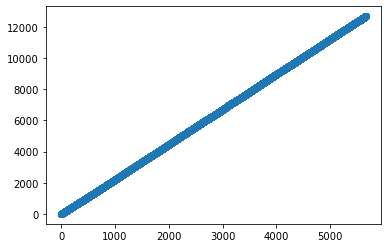

In [264]:
plt.scatter(sorted(df_keras.customer.values),range(len(df_keras.customer.values)) )

In [265]:
df_keras.customer.value_counts()

3082    15
1346    13
611      9
4468     9
2316     8
        ..
3763     2
1714     2
3755     2
1706     2
2047     2
Name: customer, Length: 5664, dtype: int64

In [266]:
df_test = df_keras.sort_values('order_purchase_timestamp', ascending=False).groupby(['customer']).head(1)

In [276]:
df_train = df_keras[~df_keras.index.isin(df_test.index)]

In [277]:
df_test[df_test.customer == 51762].order_purchase_timestamp.max()

nan

In [278]:
df_train[df_train.customer == 51762].order_purchase_timestamp.max()

nan

In [279]:
print(len(df_keras), len(df_test), len(df_train))

12696 5664 7032


In [280]:
df_train.head()

,customer_unique_id,product_id,review_score,order_purchase_timestamp,customer,item,rating
1242,7a1de9bde89aedca8c5fbad489c5571c,be03d93320192443b8fa24c0ca6ead98,1,2017-08-24 11:31:28,2670,5772,0
6417,07f61caa1c9e850c14e94854cec87545,0bb7cb61f1957f79dac582ab66ccdc1f,5,2017-08-05 14:52:23,184,343,1
28528,7289ef64c73bc18f265634e530689474,d961667356e6dffef33c0d0eb4c327cc,5,2017-09-30 14:48:37,2481,6628,1
49787,330fdaa06f93c0c6ffb4af7d79c1ef12,d6771ada82143b0a04ba2cf7690bfcc7,1,2017-08-28 20:15:12,1125,6541,0
52842,ddba0e0afb9e4924ca45fc487b19a17a,a7c9b5877966d71112d9a1b392fef8d1,5,2018-06-06 17:30:59,4903,5099,1


In [281]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

X_train = [df_train.loc[:,'customer'].values, df_train.loc[:,'item'].values] 
y_train = df_train.rating

X_test = [df_test.loc[:,'customer'].values, df_test.loc[:,'item'].values]
y_test = df_test.rating

In [297]:
X_train[1]

array([1024,  251, 3366, ..., 5011, 6475, 4314])

In [296]:
X_test[1]

array([5371,  351,  493, ..., 2211, 4886, 7302])

In [298]:
y_train

11122987    0
12547552    0
3232841     0
14288716    0
6312629     1
           ..
5510130     1
1027901     0
14264406    1
4642588     1
12671461    1
Name: rating, Length: 7032, dtype: int64

In [299]:
y_test

14259258    0
4692363     0
3094234     0
5621318     1
4939004     1
           ..
8852845     0
3566907     0
13642928    0
9381721     1
12444496    0
Name: rating, Length: 5664, dtype: int64

In [323]:
n_factors = 10

In [324]:
print(n_customers, n_items, n_factors, 0, 1, 1)
model = RecommenderNet(n_customers+1, n_items+1, n_factors, 0, 1, 1)
history = model.fit(x=X_train, y=y_train, batch_size=512, epochs=100,
                    verbose=1, validation_data=(X_test, y_test))

5663 7802 10 0 1 1
Epoch 1/100
14/14 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6927 - val_accuracy: 0.5344
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5958 - val_loss: 0.6917 - val_accuracy: 0.5800
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.6351 - val_loss: 0.6901 - val_accuracy: 0.6199
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.6748 - val_loss: 0.6877 - val_accuracy: 0.6418
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.7196 - val_loss: 0.6840 - val_accuracy: 0.6471
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.7551 - val_loss: 0.6785 - val_accuracy: 0.6675
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.7982 - val_loss: 0.6709 - val_accuracy: 

In [325]:
model.evaluate(X_test, y_test)

177/177 [==============================] - 0s 897us/step - loss: 0.6541 - accuracy: 0.8468


[0.6541016697883606, 0.8467513918876648]

In [326]:
y_pred = model.predict(X_test)#.astype(int).flatten()
y_pred = np.rint(y_pred)

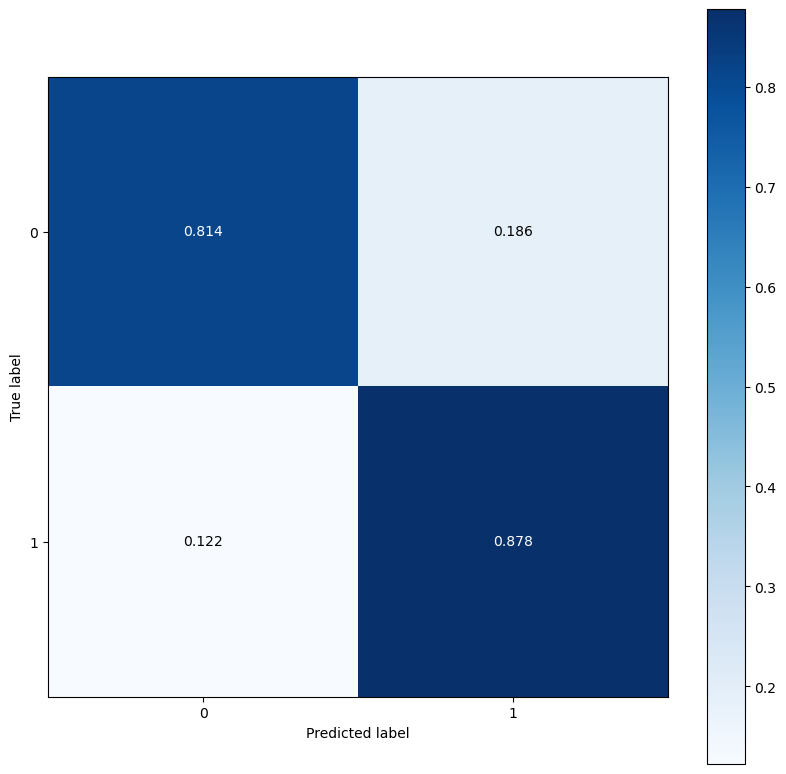

In [327]:
plot_confusion_matrix(y_test, y_pred, save_path='conf_matrix_binary.png')

## Multiclass approach

In [111]:
X = df_keras[['customer', 'item']].values
y = df_keras['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48449, 2), (23864, 2), (48449,), (23864,))

In [112]:
n_factors = 50 #first hyperparameter to tune

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [113]:
model = RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating)
history = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/10
95/95 [==============================] - 1s 8ms/step - loss: 1.3433 - accuracy: 0.5030 - val_loss: 0.4437 - val_accuracy: 0.8944
Epoch 2/10
95/95 [==============================] - 1s 6ms/step - loss: 0.3432 - accuracy: 0.9136 - val_loss: 0.0720 - val_accuracy: 0.9909
Epoch 3/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0833 - accuracy: 0.9859 - val_loss: 0.0201 - val_accuracy: 0.9940
Epoch 4/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0376 - accuracy: 0.9924 - val_loss: 0.0130 - val_accuracy: 0.9938
Epoch 5/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.0112 - val_accuracy: 0.9941
Epoch 6/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0108 - val_accuracy: 0.9939
Epoch 7/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0179 - accuracy: 0.9933 - val_loss: 0.0107 - val_accuracy: 0.9939
Epoch 8/10
95/95 [==

In [114]:
y_pred = model.predict(X_test_array)#.astype(int).flatten()
y_pred = np.argmax(y_pred, axis=1)

In [65]:
def plot_confusion_matrix(test_labels, predicted_labels, save_path=None, encoder=None):
    if encoder:
      test_labels = encoder.inverse_transform(test_labels)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=[10, 10], dpi=100)
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    classes = unique_labels(test_labels, predicted_labels)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.3f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

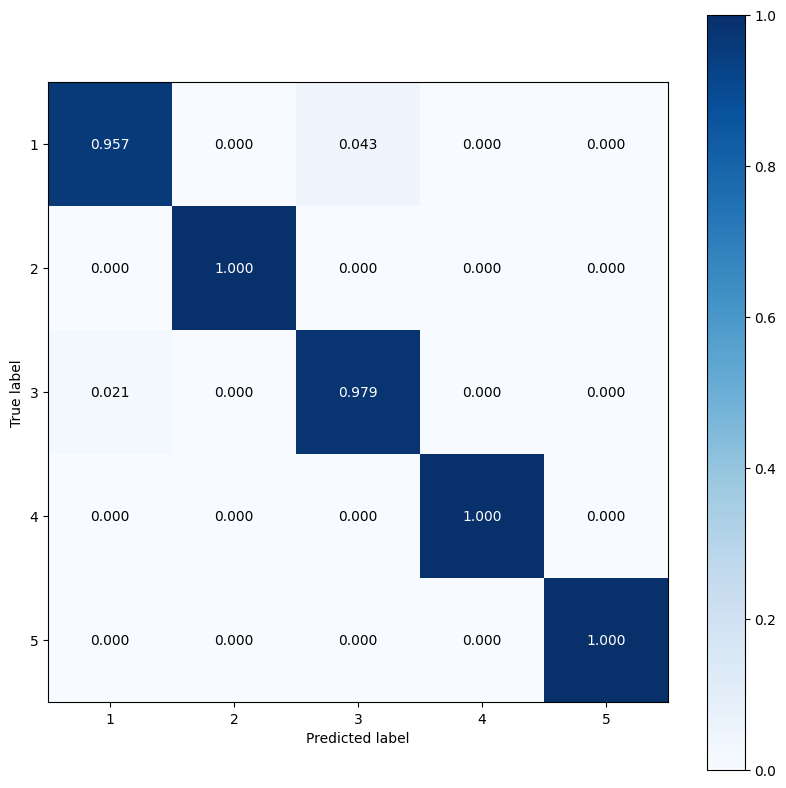

In [80]:
plot_confusion_matrix(y_test, y_pred, encoder=rating_enc)


# Cross validation
Based on https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [122]:
n_splits = 5
kf = KFold(n_splits, shuffle=True)

In [89]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [116]:

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for fold_var, (train_index, val_index) in enumerate(kf.split(X,y)):
  X_train = X[train_index]
  X_test = X[val_index]

  X_train_array = [X_train[:, 0], X_train[:, 1]]
  X_test_array = [X_test[:, 0], X_test[:, 1]] 

  y_train = y[train_index]
  y_test = y[val_index]

  model = RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating)
  
  
  checkpoint = ModelCheckpoint(path+'/saved_models/'+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  history = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test), callbacks=callbacks_list)
  
  model.load_weights(path+"/saved_models/model_"+str(fold_var)+".h5")
  
  results = model.evaluate(X_test_array, y_test)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  
  backend.clear_session()

Epoch 1/10
113/113 [==============================] - 1s 7ms/step - loss: 1.2282 - accuracy: 0.5747 - val_loss: 0.2503 - val_accuracy: 0.9527

Epoch 00001: val_accuracy improved from -inf to 0.95271, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 0.1978 - accuracy: 0.9569 - val_loss: 0.0390 - val_accuracy: 0.9911

Epoch 00002: val_accuracy improved from 0.95271 to 0.99108, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 3/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0546 - accuracy: 0.9905 - val_loss: 0.0157 - val_accuracy: 0.9932

Epoch 00003: val_accuracy improved from 0.99108 to 0.99315, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 4/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0276 - accuracy: 0.9939 - val_loss: 0.0124 - val_accuracy: 0.9934

Epoch 00004: val_accuracy improved fro

In [118]:
VALIDATION_ACCURACY = np.array(VALIDATION_ACCURACY)

In [123]:
print(f'Mean accuracy of the {n_splits}-split cross validation: {VALIDATION_ACCURACY.mean():.2f}({VALIDATION_ACCURACY.std():.2f})')

Mean accuracy of the 5-split cross validation: 0.99(0.00)
